In [3]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.optim as optimizer
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from tqdm.auto import tqdm
from glob import glob
from os import path
from torchvision.utils import save_image
import torch.nn as nn
from torch.nn import init
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
import cv2
from IPython.display import clear_output
from matplotlib.colors import LinearSegmentedColormap
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
import seaborn as sns
# !pip install seaborn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

```python
dataset shape -> [modality, h, d, w]
dataset  -> data[0] : MR_Flair
dataset  -> data[1] : MR_T1
dataset  -> data[2] : MR_T1c
dataset  -> data[3] : MR_T2
[1] label necrosis
[2] label edema
[3] label non-enhancing tumor
[4] label enhancing tumor
[0] label everything else
one-hot: 
    [0] label normal
    [1] label necrosis
    [2] label edema
    [3] label non-enhancing tumor
    [4] label enhancing tumor
```

In [4]:
class Classification_Dataset(Dataset):
    '''
    input : index list 0 ~ 3724
    '''
    def __init__(self, index_list):
        self.index_list = index_list

    def __len__(self):        
        return len(self.index_list)


    def __getitem__(self, index):   
        MR_Flair = Image.open("./BRATS_Padding/image/MR_Flair/{}.png".format(self.index_list[index])).convert('L')
        MR_T1 = Image.open("./BRATS_Padding/image/MR_T1/{}.png".format(self.index_list[index])).convert('L')
        MR_T1c = Image.open("./BRATS_Padding/image/MR_T1c/{}.png".format(self.index_list[index])).convert('L')
        MR_T2 = Image.open("./BRATS_Padding/image/MR_T2/{}.png".format(self.index_list[index])).convert('L')
        
        target0 = Image.open("./BRATS_Padding/label/0/{}.png".format(self.index_list[index])).convert('L')
        target1 = Image.open("./BRATS_Padding/label/1/{}.png".format(self.index_list[index])).convert('L')
        target2 = Image.open("./BRATS_Padding/label/2/{}.png".format(self.index_list[index])).convert('L')
        target3 = Image.open("./BRATS_Padding/label/3/{}.png".format(self.index_list[index])).convert('L')
        target4 = Image.open("./BRATS_Padding/label/4/{}.png".format(self.index_list[index])).convert('L')
        
        trans = transforms.Compose([transforms.ToTensor()])
        MR_Flair, MR_T1, MR_T1c, MR_T2 = trans(MR_Flair), trans(MR_T1), trans(MR_T1c), trans(MR_T2)
        target0, target1, target2, target3, target4 = trans(target0), trans(target1), trans(target2), trans(target3), trans(target4)
        image = torch.stack((MR_Flair, MR_T1, MR_T1c, MR_T2)).squeeze(1)
        target = torch.stack((target0, target1, target2, target3, target4)).squeeze(1)
        
        return image, target

In [5]:
indx = np.arange(3725)
np.random.shuffle(indx)
print(3725*0.2, 3725*0.2, 3725*0.2+3725*0.2)

745.0 745.0 1490.0


In [6]:
test_index = indx[:745]
valid_index = indx[746:1490]
train_index = indx[1490:]

In [7]:
test_index.shape, valid_index.shape, train_index.shape

((745,), (744,), (2235,))

In [8]:
train_dataset = Classification_Dataset(train_index)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

In [9]:
valid_dataset = Classification_Dataset(valid_index)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=5, shuffle=True)

In [10]:
test_dataset = Classification_Dataset(test_index)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)

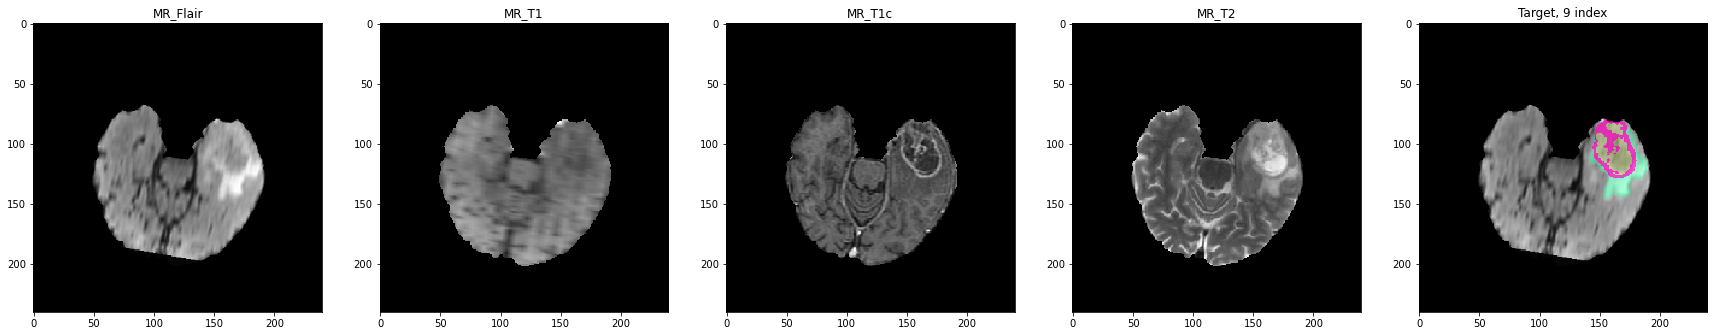

In [11]:
def imshow1(img):
    plt.imshow(img, cmap='gray',  interpolation='none')
def imshow2(mask):
    plt.imshow(mask, cmap=map_object, alpha=0.7,  interpolation='none')


# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)
i=0
for img, label in train_loader:
    plt.figure(figsize=(30,30))
    plt.subplot(1,5,1)
    plt.title('MR_Flair')
    imshow1(img[0][0])
    plt.subplot(1,5,2)
    plt.title('MR_T1')
    imshow1(img[0][1])
    plt.subplot(1,5,3)
    plt.title('MR_T1c')
    imshow1(img[0][2])
    plt.subplot(1,5,4)
    plt.title('MR_T2')
    imshow1(img[0][3])
    plt.subplot(1,5,5)
    plt.title('Target, {} index'.format(i))
    imshow1(img[0][0])
    imshow2((label[0][1]+label[0][2]*2+label[0][3]*3+label[0][4]*4))
    
    plt.show()
    i+=1
    if i == 10:
        break
    clear_output(wait=True)

## Model

In [12]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class ConvBlock2(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock2, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=7, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, F_g, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_g),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out
    
class AttentionBlock_2(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l_1, F_l_2, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock_2, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x1 = nn.Sequential(
            nn.Conv2d(F_l_1, n_coefficients, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_coefficients)
        )
        
        self.W_x2 = nn.Sequential(
            nn.Conv2d(F_l_2, n_coefficients, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_coefficients)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, F_g, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_g),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection, skip_connection_2):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        # print('g1.shape: {} , x1.shape: {}, x2.shape{} '.format(gate.shape,skip_connection.shape,skip_connection_2.shape))
        
        g1 = self.W_gate(gate)
        x1 = self.W_x1(skip_connection)
        x2 = self.W_x2(skip_connection_2)
        psi = self.relu(g1 + x1 + x2)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv2_2 = ConvBlock2(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv3_2 = ConvBlock2(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv4_2 = ConvBlock2(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock_2(F_g=512, F_l_1=512, F_l_2=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock_2(F_g=256, F_l_1=256, F_l_2=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock_2(F_g=128, F_l_1=128, F_l_2=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2_1 = self.Conv2(e2)
        e2_2 = self.Conv2_2(e2)

        e3 = self.MaxPool(e2_1)
        e3_1 = self.Conv3(e3)
        e3_2 = self.Conv3_2(e3)

        e4 = self.MaxPool(e3_1)
        e4_1 = self.Conv4(e4)
        e4_2 = self.Conv4_2(e4)

        e5 = self.MaxPool(e4_1)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4_1, skip_connection_2=e4_2)
        d5 = torch.cat((s4, d5), dim=1) # concatenate attention-weighted skip connection with previous layer output
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3_1, skip_connection_2=e3_2)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2_1, skip_connection_2=e2_2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return self.softmax(out)


In [13]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
           
        # compute the negative likelyhood
        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [14]:
model = AttentionUNet(4, 5)
num_epoch = 40
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.BCELoss()

### for picture - 1

In [15]:
MR_Flair = Image.open("./BRATS_Padding/image/MR_Flair/444.png").convert('L')
MR_T1 = Image.open("./BRATS_Padding/image/MR_T1/444.png").convert('L')
MR_T1c = Image.open("./BRATS_Padding/image/MR_T1c/444.png").convert('L')
MR_T2 = Image.open("./BRATS_Padding/image/MR_T2/444.png").convert('L')
trans = transforms.Compose([transforms.ToTensor()])
MR_Flair, MR_T1, MR_T1c, MR_T2 = trans(MR_Flair), trans(MR_T1), trans(MR_T1c), trans(MR_T2)
pltimage = torch.stack((MR_Flair, MR_T1, MR_T1c, MR_T2)).squeeze(1).unsqueeze(0)
pltimage = pltimage.to(device)

In [16]:
pltimage.shape

torch.Size([1, 4, 240, 240])

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

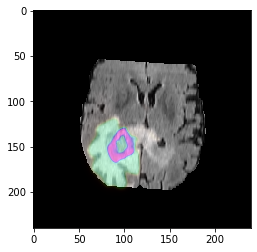

Epoch 1: train_loss : 0.2411404573744042, valid_loss : 0.05214305468384297


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

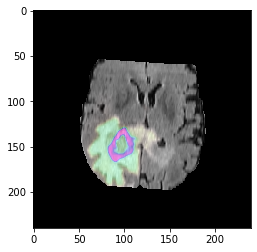

Epoch 2: train_loss : 0.04534986074305487, valid_loss : 0.04134681306701774


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

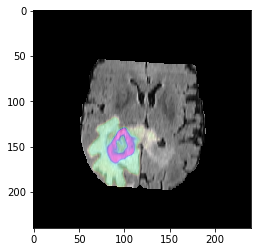

Epoch 3: train_loss : 0.036529447112474134, valid_loss : 0.03678553979934609


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

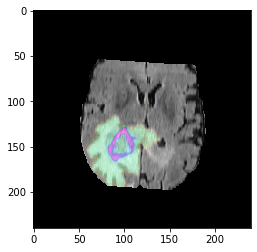

Epoch 4: train_loss : 0.03112133554239201, valid_loss : 0.03028885577085568


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

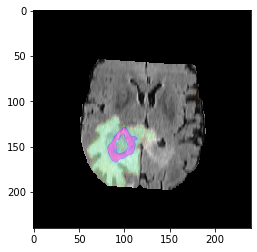

Epoch 5: train_loss : 0.029888768717896617, valid_loss : 0.029511955885594632


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

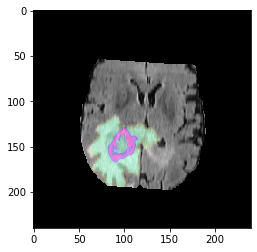

Epoch 6: train_loss : 0.027573600746857906, valid_loss : 0.025429732625437487


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

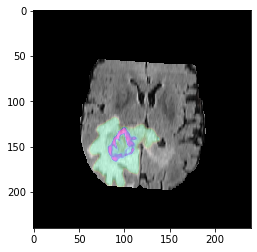

Epoch 7: train_loss : 0.02603983303211146, valid_loss : 0.02496598665894326


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

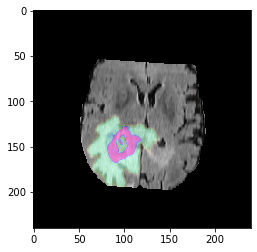

Epoch 8: train_loss : 0.024502281729815324, valid_loss : 0.0234701043454181


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

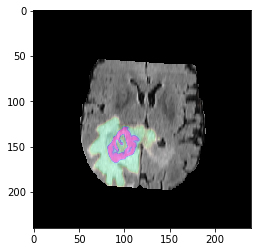

Epoch 9: train_loss : 0.022957272430979784, valid_loss : 0.023665729481029803


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

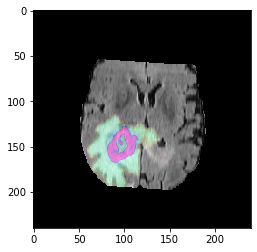

Epoch 10: train_loss : 0.022944578706126418, valid_loss : 0.02221053873591866


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

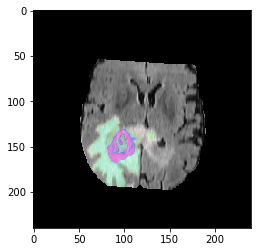

Epoch 11: train_loss : 0.021436493922445832, valid_loss : 0.033973680776515754


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

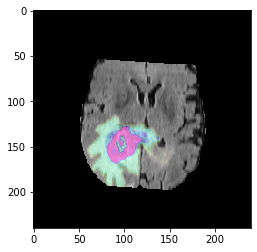

Epoch 12: train_loss : 0.020531541550551778, valid_loss : 0.019548994479244415


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

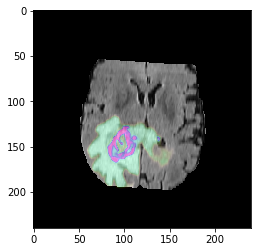

Epoch 13: train_loss : 0.020015552957954773, valid_loss : 0.02236557522204044


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

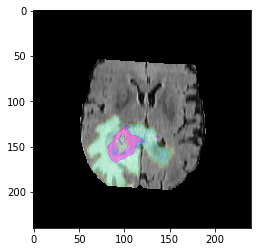

Epoch 14: train_loss : 0.018608909462692145, valid_loss : 0.01809966645391454


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

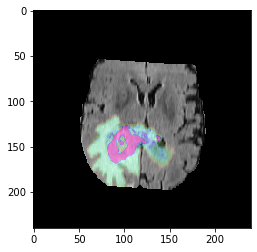

Epoch 15: train_loss : 0.016789836742237035, valid_loss : 0.01862465157522507


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

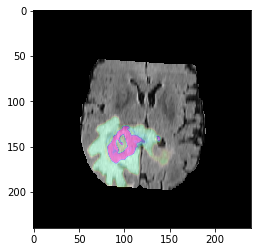

Epoch 16: train_loss : 0.017263486129763042, valid_loss : 0.01663224628267809


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

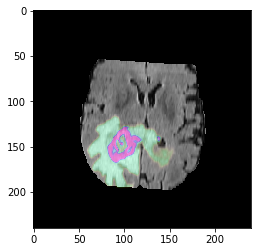

Epoch 17: train_loss : 0.016643908600139555, valid_loss : 0.0161145662165093


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

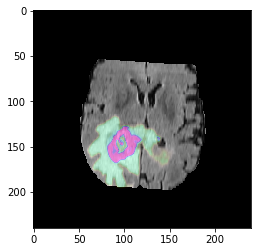

Epoch 18: train_loss : 0.015756014497248536, valid_loss : 0.015013255942258477


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

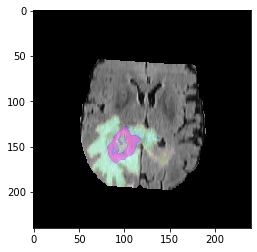

Epoch 19: train_loss : 0.016507796563535734, valid_loss : 0.016157244327949093


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

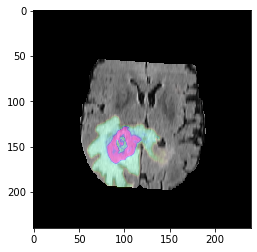

Epoch 20: train_loss : 0.015261048506701864, valid_loss : 0.021132678573175696


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

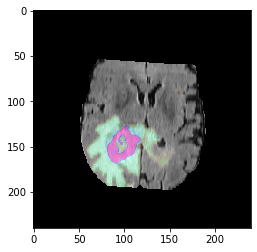

Epoch 21: train_loss : 0.015523424527427635, valid_loss : 0.015217160928137498


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

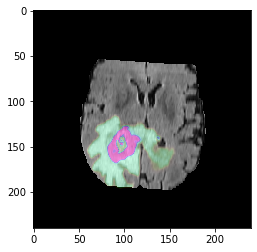

Epoch 22: train_loss : 0.01419585481805881, valid_loss : 0.014358926723601936


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

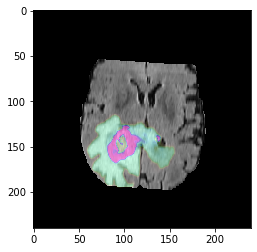

Epoch 23: train_loss : 0.014156438651609534, valid_loss : 0.014850229281721543


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

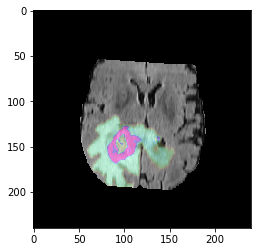

Epoch 24: train_loss : 0.013568006635127746, valid_loss : 0.013000861601816509


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

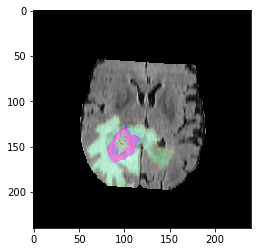

Epoch 25: train_loss : 0.013045410050852203, valid_loss : 0.01280556522469949


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

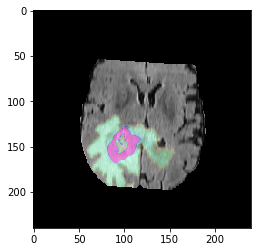

Epoch 26: train_loss : 0.012914719696815456, valid_loss : 0.011875277535813028


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

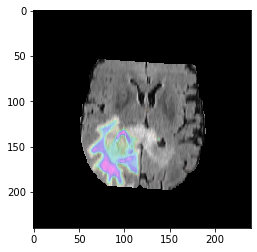

Epoch 27: train_loss : 0.0280627355233962, valid_loss : 0.0534426078725461


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

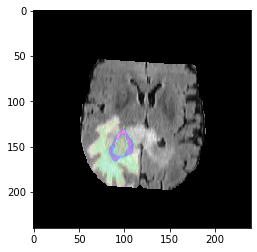

Epoch 28: train_loss : 0.044054236460968815, valid_loss : 0.04514285423037138


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

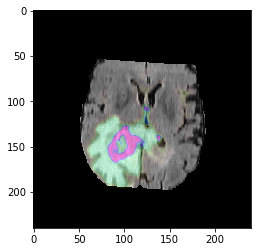

Epoch 29: train_loss : 0.036596350701029935, valid_loss : 0.038378158113529584


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

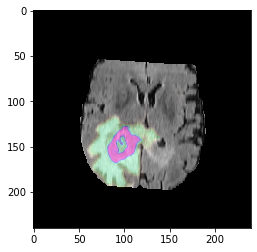

Epoch 30: train_loss : 0.029864917736358822, valid_loss : 0.02569919868670128


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

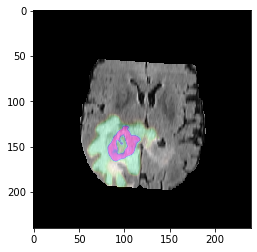

Epoch 31: train_loss : 0.02594001231281716, valid_loss : 0.02610006024167555


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

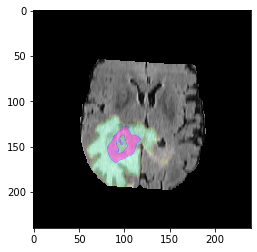

Epoch 32: train_loss : 0.023745686750258975, valid_loss : 0.01950352900023982


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

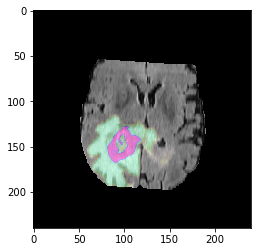

Epoch 33: train_loss : 0.02104081228267093, valid_loss : 0.018296223597202187


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

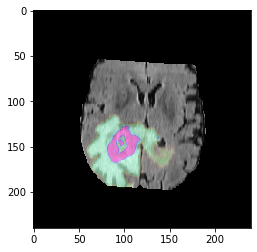

Epoch 34: train_loss : 0.019878920829194437, valid_loss : 0.018258905983828455


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

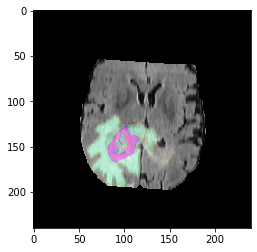

Epoch 35: train_loss : 0.018105014821647832, valid_loss : 0.016556877527691735


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

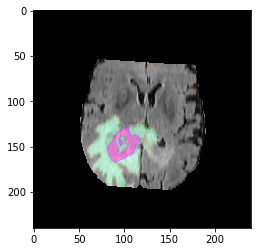

Epoch 36: train_loss : 0.017749030801602502, valid_loss : 0.02040651451243235


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

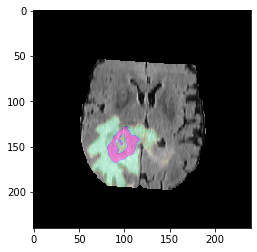

Epoch 37: train_loss : 0.017252517390503472, valid_loss : 0.01697392227125696


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

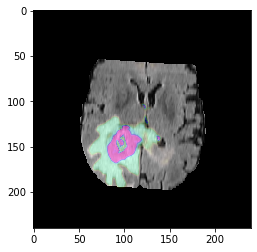

Epoch 38: train_loss : 0.016203200688217904, valid_loss : 0.018625592943550068


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

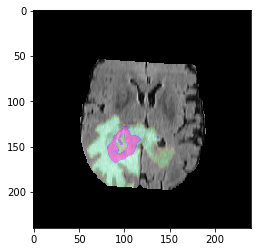

Epoch 39: train_loss : 0.016393332583808925, valid_loss : 0.014258544545148735


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

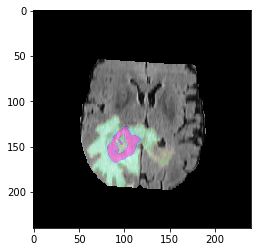

Epoch 40: train_loss : 0.015634935083840736, valid_loss : 0.013500338624983973


In [20]:
def Bimshow(img):
    plt.imshow(np.transpose(img), cmap=map_object, alpha=0.4)  
    
model = model.to(device)
min_valid_loss = np.inf
train_loss_list = []
valid_loss_list = []

for i in tqdm(range(num_epoch)):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    
    for image,label in tqdm(train_loader, leave=False):
      
        optimizer.zero_grad()
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        
        loss = loss_func(output[:,1:], label[:,1:])*5.0   #0:normal data 
        # too many pixel is normal. so discount the normal loss
        loss += loss_func(output[:,0], label[:, 0]) * 0.2 
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*image.size(0)#
        
    model.eval()
    
    for image, label in tqdm(valid_loader, leave=False):
      
        image = image.to(device)
        label = label.to(device)
        
        output = model(image)
        
        loss = loss_func(output[:,1:], label[:,1:])*5.0
        # too many pixel is normal. so discount the normal loss
        loss += loss_func(output[:,0], label[:, 0]) * 0.2
        
        valid_loss += loss.item()*image.size(0)
    if min_valid_loss>=valid_loss:
        # torch.save(model.module.state_dict(),'model_best_'+ str(fold) + '.pt')
        torch.save(model.state_dict(), './model/gate_3_model_{}.pt'.format(i+1))
    pltimage = pltimage.to(device)
    pltout = model(pltimage)
    # pltout[pltout < 0.5] = 0
    # pltout[pltout > 0.5] = 1

    imshow1(pltimage[0][0].detach().cpu().numpy())
    Bimshow(torch.squeeze(pltout).detach().cpu().numpy()[1].T + torch.squeeze(pltout).detach().cpu().numpy()[2].T*2 + torch.squeeze(pltout).detach().cpu().numpy()[3].T*3 + torch.squeeze(pltout).detach().cpu().numpy()[4].T*4)
    # plt.savefig('./image/learning_image_{}epoch.png'.format(i), dpi=300, facecolor='w')    
    plt.show()
    
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    
    
    print('Epoch {}: train_loss : {}, valid_loss : {}'.format(i+1, train_loss, valid_loss))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)


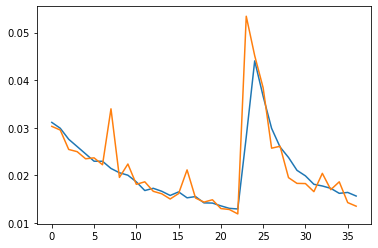

best epoch:  24


In [23]:
plt.plot(train_loss_list[3:])
plt.plot(valid_loss_list[3:])
plt.show()
print('best epoch: ',np.argmin(valid_loss_list)-1)
best = np.argmin(valid_loss_list)-1
# plt.savefig('fig1.png', dpi=300, facecolor='w')

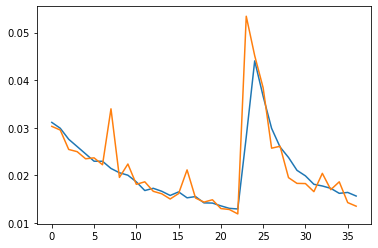

In [21]:
plt.plot(train_loss_list[3:])
plt.plot(valid_loss_list[3:])
plt.savefig('Model_2_loss.png', dpi=300, facecolor='w')
plt.show()

## Dice, Specificity, Sensitivity

In [24]:
def dice(prediction, GT):
    # 2*(예측병변과 실제 병변의 교집합)/예측 병변 크기+실제 병변 크기
    pred_seg=np.sum(prediction*GT, axis=(2,3))*2
    real_seg=np.sum(prediction, axis=(2,3)) + np.sum(GT, axis=(2,3))
    
    enhancing = np.sum(pred_seg[:, 1] + pred_seg[:, 4])                                              # necrosis[1] + enhanced tumor[4]
    core = np.sum(pred_seg[:, 1] + pred_seg[:, 4] + pred_seg[:, 3])                                  # necrosis[1] + enhanced tumor[4] + non-enhanced tumor[3]
    complete = np.sum(pred_seg[:, 1] + pred_seg[:, 4] + pred_seg[:, 3] + pred_seg[:, 2])             # necrosis[1] + enhanced tumor[4] + non-enhanced tumor[3] + edema[2]
    
    enhancing_real_seg = np.sum(real_seg[:, 1] + real_seg[:, 4])
    core_real_seg = np.sum(real_seg[:, 1] + real_seg[:, 4] + real_seg[:, 3])
    complete_real_seg = np.sum(real_seg[:, 1] + real_seg[:, 4] + real_seg[:, 3] + real_seg[:, 2])
    
    return  enhancing, core, complete, enhancing_real_seg, core_real_seg, complete_real_seg

def sensitivity(prediction, GT): 
    # 잘 예측된 병변/실제 병변
    pred_seg=np.sum(prediction*GT, axis=(2,3))
    real_seg=np.sum(GT, axis=(2,3))
    
    enhancing = np.sum(pred_seg[:, 1] + pred_seg[:, 4])                                              # necrosis[1] + enhanced tumor[4]
    core = np.sum(pred_seg[:, 1] + pred_seg[:, 4] + pred_seg[:, 3])                                  # necrosis[1] + enhanced tumor[4] + non-enhanced tumor[3]
    complete = np.sum(pred_seg[:, 1] + pred_seg[:, 4] + pred_seg[:, 3] + pred_seg[:, 2])             # necrosis[1] + enhanced tumor[4] + non-enhanced tumor[3] + edema[2]
    
    enhancing_real_seg = np.sum(real_seg[:, 1] + real_seg[:, 4])
    core_real_seg = np.sum(real_seg[:, 1] + real_seg[:, 4] + real_seg[:, 3])
    complete_real_seg = np.sum(real_seg[:, 1] + real_seg[:, 4] + real_seg[:, 3] + real_seg[:, 2])
    
    return  enhancing, core, complete, enhancing_real_seg, core_real_seg, complete_real_seg

def specificity(prediction, GT): 
    # 잘 예측된 정상/실제 정상
    pred_seg=np.sum((prediction==0)*(GT==0), axis=(2,3))
    real_seg=np.sum(GT==0, axis=(2,3))

    enhancing = np.sum(pred_seg[:, 1] + pred_seg[:, 4])                                              # necrosis[1] + enhanced tumor[4]
    core = np.sum(pred_seg[:, 1] + pred_seg[:, 4] + pred_seg[:, 3])                                  # necrosis[1] + enhanced tumor[4] + non-enhanced tumor[3]
    complete = np.sum(pred_seg[:, 1] + pred_seg[:, 4] + pred_seg[:, 3] + pred_seg[:, 2])             # necrosis[1] + enhanced tumor[4] + non-enhanced tumor[3] + edema[2]
    
    enhancing_real_seg = np.sum(real_seg[:, 1] + real_seg[:, 4])
    core_real_seg = np.sum(real_seg[:, 1] + real_seg[:, 4] + real_seg[:, 3])
    complete_real_seg = np.sum(real_seg[:, 1] + real_seg[:, 4] + real_seg[:, 3] + real_seg[:, 2])

    return  enhancing, core, complete, enhancing_real_seg, core_real_seg, complete_real_seg
        

In [25]:
def test(model,model_2, test_loader, loss_func, device):
    '''
    dataset shape -> [modality, h, d, w]
    dataset  -> data[0] : MR_Flair
    dataset  -> data[1] : MR_T1
    dataset  -> data[2] : MR_T1c
    dataset  -> data[3] : MR_T2
    one-hot: 
        [0] label necrosis
        [1] label edema
        [2] label non-enhancing tumor
        [3] label enhancing tumor
    '''
    model = model.to(device)
    model.eval()
    enhancing = 0.0 # necrosis[1] + enhanced tumor[4]
    core = 0.0      # necrosis[1] + enhanced tumor[4] + non-enhanced tumor[3]
    complete = 0.0  # necrosis[1] + enhanced tumor[4] + non-enhanced tumor[3] + edema[2]
    enhancing_real_seg = 0.0
    core_real_seg = 0.0     
    complete_real_seg = 0.0 
    
    for image, label in tqdm(test_loader, leave=False):
        image = image.to(device)
        label = label.to(device)
        
        output = model(image)
        output[output < 0.5] = 0
        output[output > 0.5] = 1
        
        en, co, com, en_real_seg, co_real_seg, com_real_seg  = loss_func(output.detach().cpu().numpy(), label.detach().cpu().numpy())
        
        enhancing += en
        core += co
        complete += com
        enhancing_real_seg += en_real_seg
        core_real_seg += co_real_seg
        complete_real_seg += com_real_seg
        
        
        
    enhancing, core, complete = enhancing/enhancing_real_seg, core/core_real_seg, complete/complete_real_seg
    
    return  complete, core, enhancing

In [26]:
model = model.to(device)
sens = sensitivity
spec = specificity
dic = dice

In [44]:
print('DICE : ', test(model, test_loader, dic, device))
print('Specificity : ', test(model, test_loader, spec, device))
print('Sensitivity : ', test(model, test_loader, sens, device))

  0%|          | 0/149 [00:00<?, ?it/s]

DICE :  (0.8340170602563741, 0.7926374769833862, 0.8514642606311269)


  0%|          | 0/149 [00:00<?, ?it/s]

Specificity :  (0.9995989520056809, 0.9997169236876482, 0.9996407343283837)


  0%|          | 0/149 [00:00<?, ?it/s]

Sensitivity :  (0.8043249146064277, 0.7636251911855071, 0.8662355865573088)


## Confusion_matrix

In [45]:
def confusion_matrix(pred, target, class_name):
    
    cm_pred = np.zeros((len(class_name), len(class_name)))
    cm_target = np.zeros((len(class_name), len(class_name)))
    
    for i in range(len(class_name)):
        mask = target == i
        pred_mask = pred[mask]
        for j in range(len(class_name)):
            cm_pred[i, j] = torch.sum(pred_mask==j)
            cm_target[i, j] = torch.sum(mask)
            
    return cm_pred, cm_target

In [46]:
def test_confusion_matrix(model, test_loader, device):
    '''
    dataset shape -> [modality, h, d, w]
    dataset  -> data[0] : MR_Flair
    dataset  -> data[1] : MR_T1
    dataset  -> data[2] : MR_T1c
    dataset  -> data[3] : MR_T2
    one-hot: 
        [0] label normal
        [1] label necrosis
        [2] label edema
        [3] label non-enhancing tumor
        [4] label enhancing tumor
    '''
    class_name = ['normal', 'necrosis', 'edema', 'non-enhancing tumer', 'enhancing tumer']
    model = model.to(device)
    model.eval()
    cm_pred = np.zeros((len(class_name), len(class_name)))
    cm_target = np.zeros((len(class_name), len(class_name)))
    for image, label in tqdm(test_loader, leave=False):
        image = image.to(device)
        label = label.to(device)
        
        output = model(image)
        pred = torch.topk(output, 1, dim=1).indices
        target = torch.topk(label, 1, dim=1).indices
        
        cm_p, cm_t  = confusion_matrix(pred, target, class_name)
        cm_pred += cm_p
        cm_target += cm_t
        
    cm = np.round(cm_pred/cm_target, 2)
    ax = sns.heatmap(cm, annot=True)
    ax.set_yticklabels(class_name, rotation=0)
    ax.set_xticklabels(class_name, rotation=15)
    # plt.savefig('attention_unet_confusion_matrix.png', dpi=300, facecolor='w')
    
    return  plt.show()

  0%|          | 0/149 [00:00<?, ?it/s]

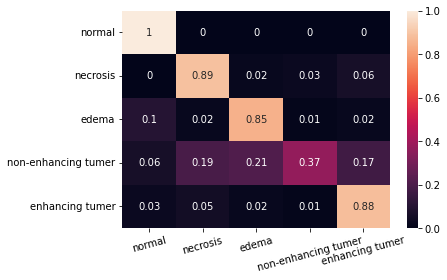

In [47]:
test_confusion_matrix(model, test_loader, device)

## Picture - 2

In [27]:
def Bimshowhot(img):
    plt.imshow(img, cmap=map_object, alpha=0.3) 

def Bimshow(img):
    plt.imshow(img, cmap='gray') 

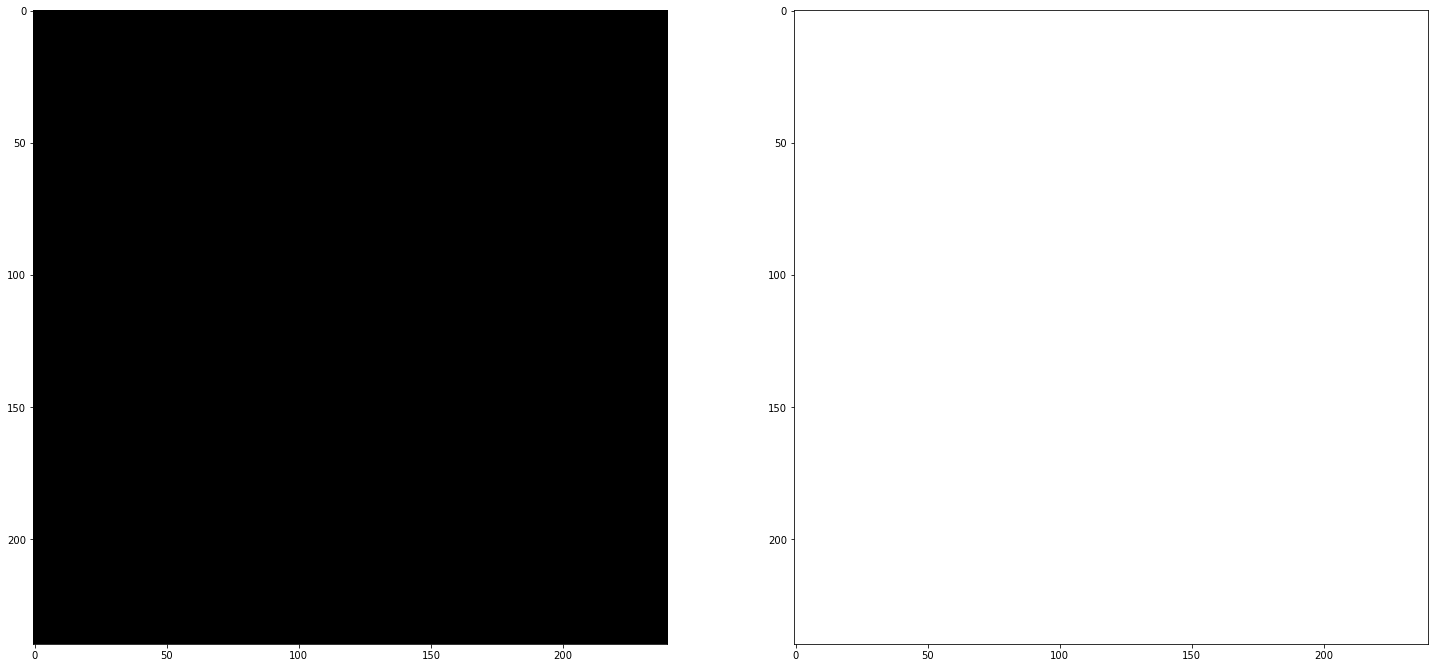

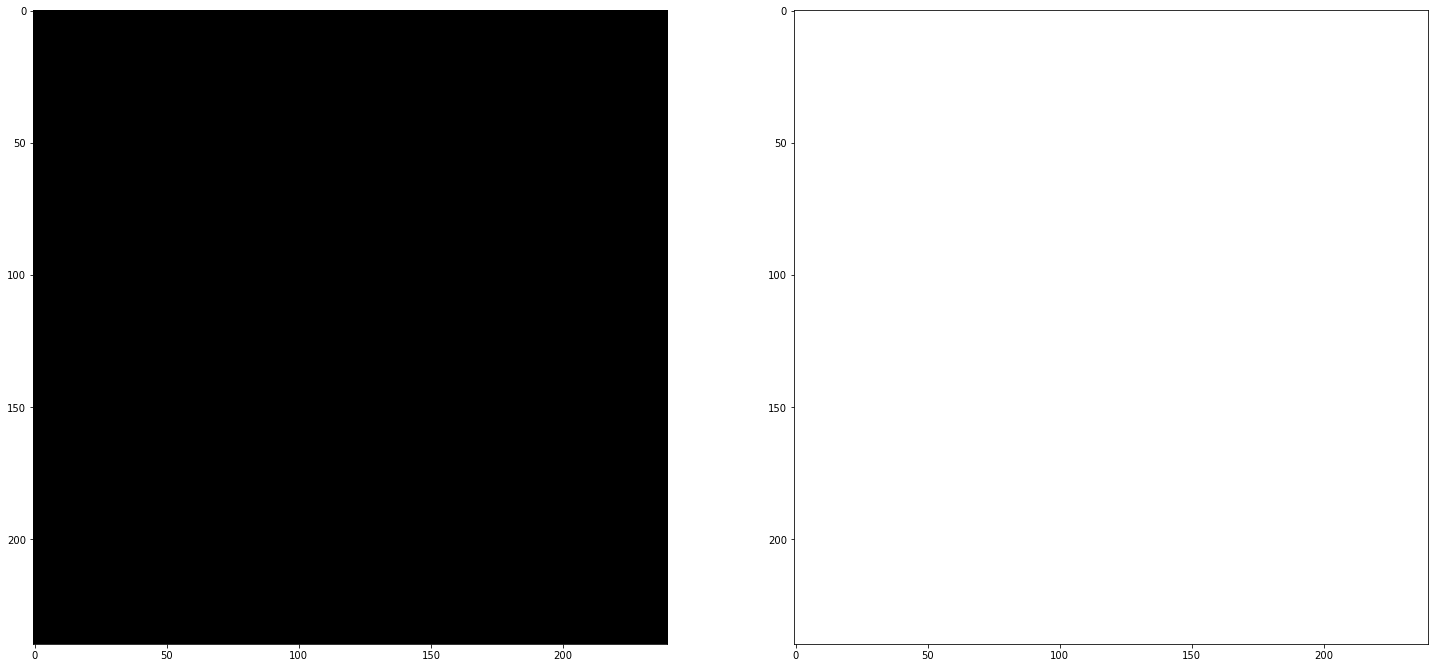

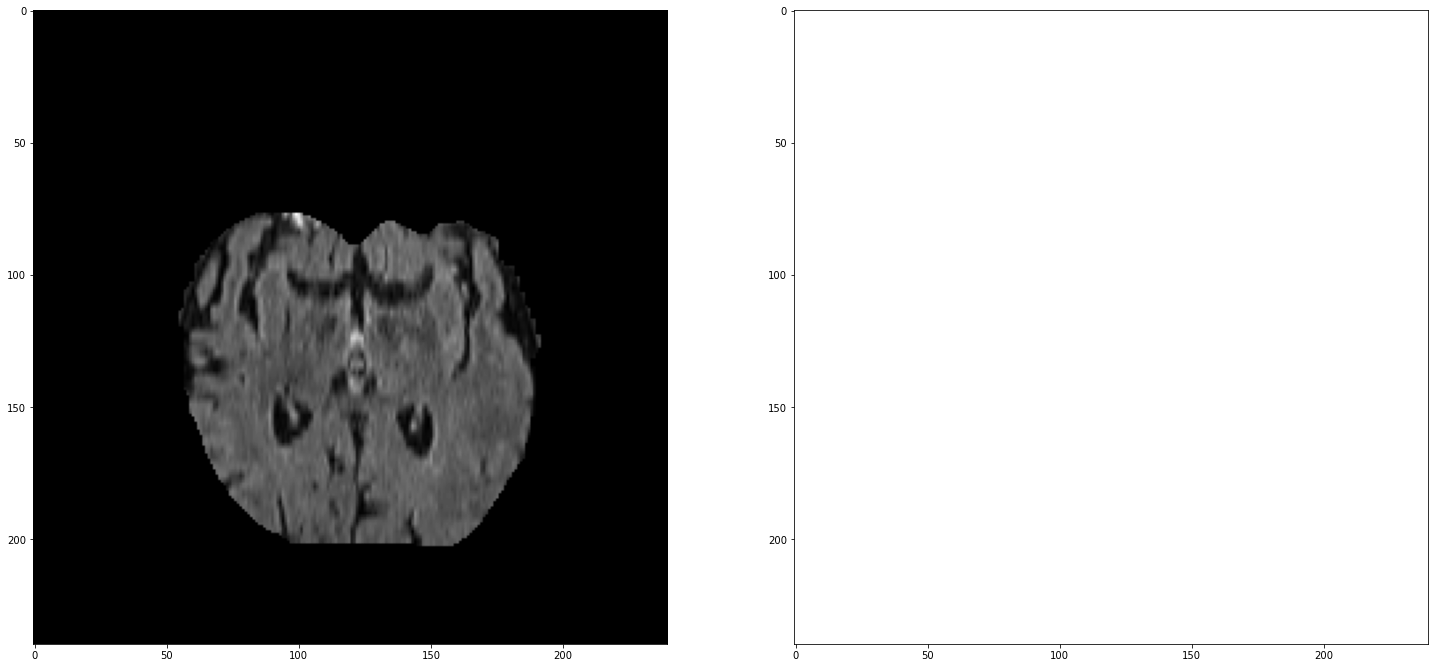

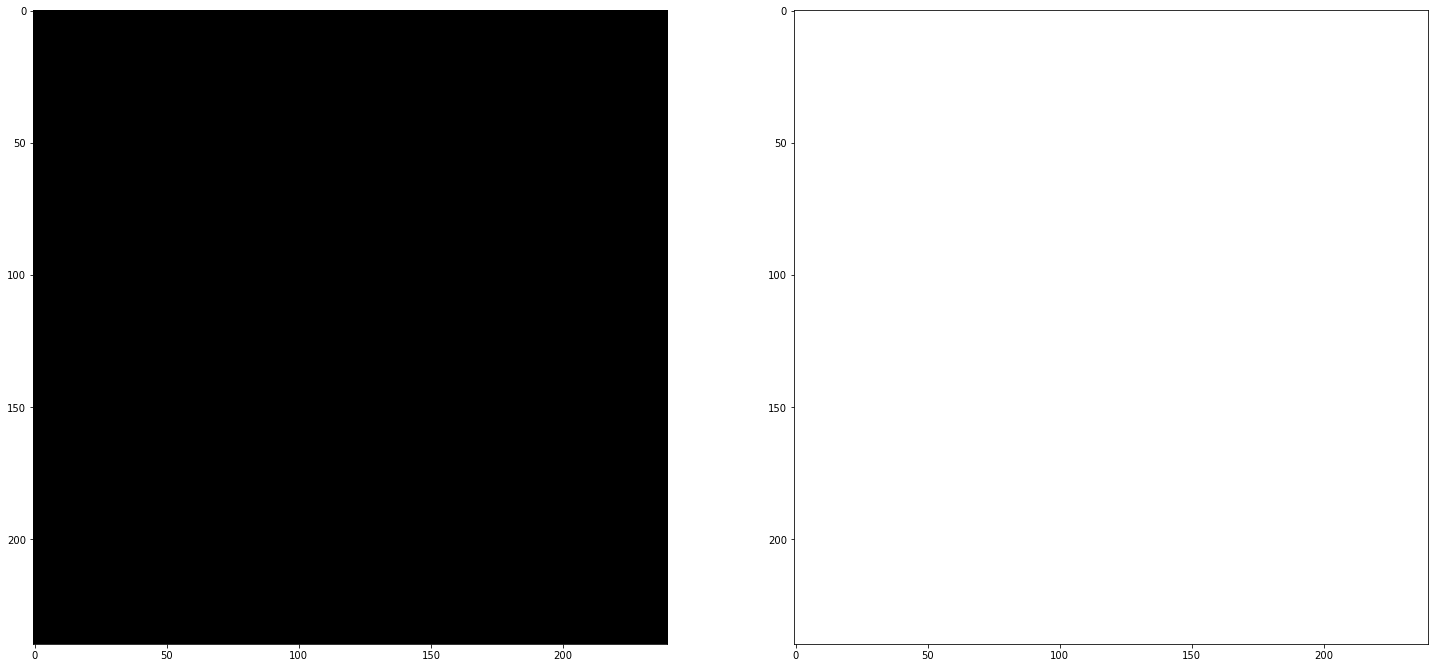

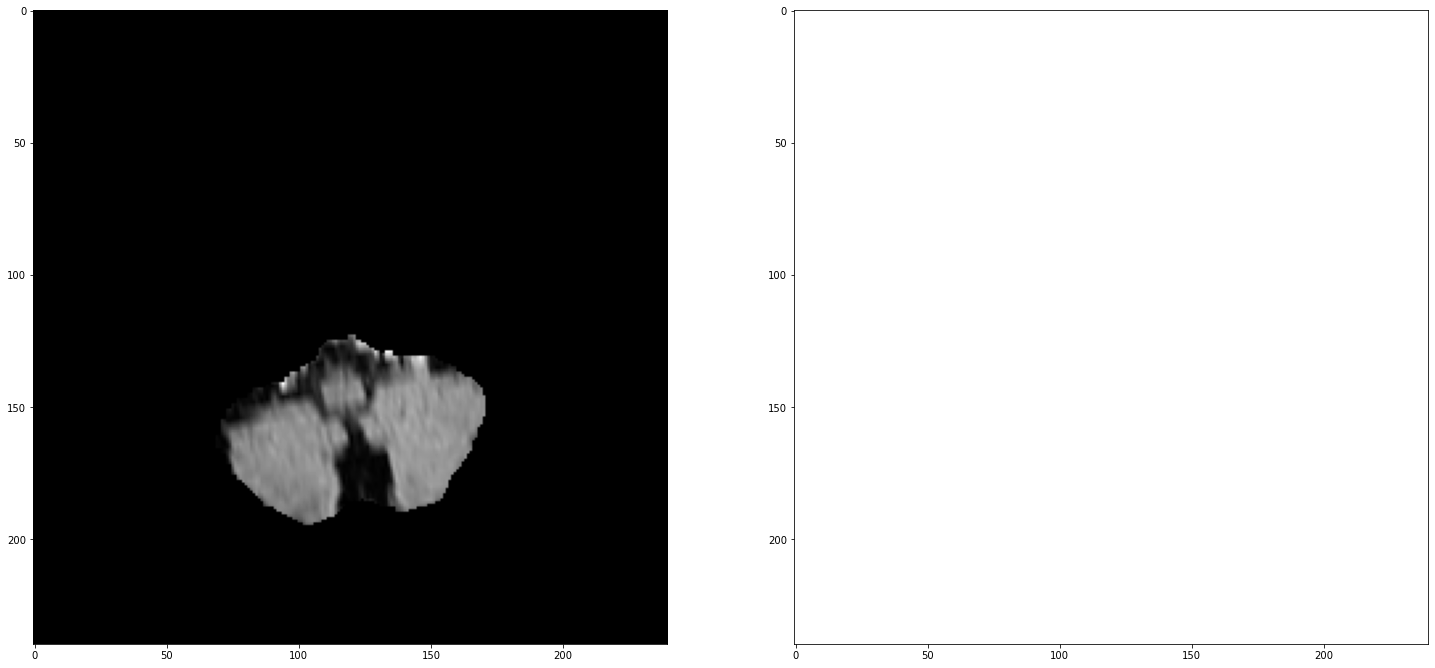

In [28]:
data, label = next(iter(test_loader))
data, label = data.to(device), label.to(device)
out = model(data)
# print(out.shape)
pred = torch.topk(out, 1, dim=1).indices
target = torch.topk(label, 1, dim=1).indices

for i in range(5):
    plt.figure(figsize=(25, 25))
    plt.subplot(1,2,1)
    Bimshow(data[i][0].detach().cpu().numpy())
    Bimshowhot(pred[i][0].detach().cpu().numpy())
    plt.subplot(1,2,2)
    Bimshowhot(target[i][0].detach().cpu().numpy())
    plt.show()